In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from catboost import CatBoostRegressor

# Load data
df = pd.read_excel('new_scraped_data_for_analytics_new.xlsx', sheet_name='new_scraped_data_for_analytics_')
print(df.head())
print(df.info())


           Player                 Club      Value  Age Position   Nation  \
0   Kylian Mbappe  Paris Saint-Germain  144000000   22   attack   France   
1  Erling Haaland    Borussia Dortmund  117000000   21   attack   Norway   
2      Harry Kane    Tottenham Hotspur  108000000   28   attack  England   
3    Jadon Sancho    Manchester United   90000000   21   attack  England   
4   Mohamed Salah         Liverpool FC   90000000   29   attack    Egypt   

  Contract Years          League  Matches Played  Total Mins  Total Mins/90   \
0              1         Ligue 1            31.0      2380.0            26.4   
1              3      Bundesliga            28.0      2407.0            26.7   
2              3  Premier League            35.0      3082.0            34.2   
3              5  Premier League            26.0      2062.0            22.9   
4              2  Premier League            37.0      3078.0            34.2   

   Goals  Assists  Yellow Cards  Red Cards     xG  xA   Pass P

In [35]:
import pandas as pd

df = pd.read_excel('new_scraped_data_for_analytics_new.xlsx', sheet_name='new_scraped_data_for_analytics_')
print(df.columns.tolist())


['Player', 'Club', 'Value', 'Age', 'Position', 'Nation', 'Contract Years', 'League', 'Matches Played', 'Total Mins', 'Total Mins/90 ', 'Goals', 'Assists', 'Yellow Cards', 'Red Cards ', 'xG', 'xA ', 'Pass Percentage']


In [31]:
# Convert minutes to float (if needed)
df['Total Mins'] = pd.to_numeric(df['Total Mins'], errors='coerce')

# Clean position column
df['Position'] = df['Position'].str.lower().str.strip()
df['Position'] = df['Position'].replace({'midfie': 'midfield', 'attack': 'forward', 'defender': 'defense'})


In [33]:
import pandas as pd

# Load the dataset (ensure the file path is correct)
df = pd.read_excel('new_scraped_data_for_analytics_new.xlsx', sheet_name='new_scraped_data_for_analytics_')

# List all columns
print("Columns in your dataset:", df.columns.tolist())


Columns in your dataset: ['Player', 'Club', 'Value', 'Age', 'Position', 'Nation', 'Contract Years', 'League', 'Matches Played', 'Total Mins', 'Total Mins/90 ', 'Goals', 'Assists', 'Yellow Cards', 'Red Cards ', 'xG', 'xA ', 'Pass Percentage']


In [36]:
# Remove leading/trailing spaces from all column names
df.columns = df.columns.str.strip()

# Print columns again to verify
print(df.columns.tolist())


['Player', 'Club', 'Value', 'Age', 'Position', 'Nation', 'Contract Years', 'League', 'Matches Played', 'Total Mins', 'Total Mins/90', 'Goals', 'Assists', 'Yellow Cards', 'Red Cards', 'xG', 'xA', 'Pass Percentage']


In [37]:
# List of columns that should be numeric
num_cols = [
    'Value', 'Age', 'Contract Years', 'Matches Played', 'Total Mins', 'Total Mins/90',
    'Goals', 'Assists', 'Yellow Cards', 'Red Cards', 'xG', 'xA', 'Pass Percentage'
]

# Convert columns to numeric, coercing errors to NaN
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Check for missing values after conversion
print(df[num_cols].isnull().sum())


Value                0
Age                  0
Contract Years      45
Matches Played     165
Total Mins         165
Total Mins/90      165
Goals              165
Assists            165
Yellow Cards       165
Red Cards          165
xG                 165
xA                 165
Pass Percentage    370
dtype: int64


In [38]:
# Drop rows with missing values in any of the important numeric columns
df = df.dropna(subset=[
    'Age', 'Contract Years', 'Matches Played', 'Total Mins', 'Total Mins/90',
    'Goals', 'Assists', 'Yellow Cards', 'Red Cards', 'xG', 'xA', 'Pass Percentage'
])

# Check again to confirm no missing values remain
print(df[num_cols].isnull().sum())
print(f"Remaining rows: {len(df)}")


Value              0
Age                0
Contract Years     0
Matches Played     0
Total Mins         0
Total Mins/90      0
Goals              0
Assists            0
Yellow Cards       0
Red Cards          0
xG                 0
xA                 0
Pass Percentage    0
dtype: int64
Remaining rows: 1669


In [39]:
# Create per-90 stats for key columns
for col in ['Goals', 'Assists', 'xG', 'xA', 'Yellow Cards', 'Red Cards']:
    df[f'{col}_per90'] = df[col] / df['Total Mins/90']

# Show the first few rows to verify
print(df[[f'{col}_per90' for col in ['Goals', 'Assists', 'xG', 'xA', 'Yellow Cards', 'Red Cards']]].head())


   Goals_per90  Assists_per90  xG_per90  xA_per90  Yellow Cards_per90  \
0     1.022727       0.265152  0.931818  0.174242            0.189394   
1     1.011236       0.224719  0.887640  0.202247            0.074906   
2     0.672515       0.409357  0.599415  0.216374            0.029240   
3     0.349345       0.480349  0.323144  0.296943            0.000000   
4     0.643275       0.146199  0.611111  0.184211            0.000000   

   Red Cards_per90  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  


In [41]:
from category_encoders import TargetEncoder

# We'll encode based on the target 'Value'
for cat_col in ['Club', 'League', 'Nation', 'Position']:
    encoder = TargetEncoder()
    df[f'{cat_col}_enc'] = encoder.fit_transform(df[cat_col], df['Value'])

# Show the first few rows to verify
print(df[[f'{col}_enc' for col in ['Club', 'League', 'Nation', 'Position']]].head())


       Club_enc    League_enc    Nation_enc  Position_enc
0  2.488403e+07  8.670721e+06  1.229987e+07  1.464418e+07
1  1.685667e+07  1.105841e+07  1.511441e+07  1.464418e+07
2  2.117305e+07  1.947159e+07  1.749877e+07  1.464418e+07
3  2.537141e+07  1.947159e+07  1.749877e+07  1.464418e+07
4  2.443618e+07  1.947159e+07  1.617737e+07  1.464418e+07


In [42]:
import numpy as np

# Cap the target at the 99th percentile to reduce outlier influence
Q99 = df['Value'].quantile(0.99)
df['Value_capped'] = np.where(df['Value'] > Q99, Q99, df['Value'])

# Log-transform the capped target for modeling
df['log_Value'] = np.log1p(df['Value_capped'])

# Show distribution of the transformed target
print(df['log_Value'].describe())


count    1669.000000
mean       15.686187
std         1.204777
min        12.323860
25%        14.808763
50%        15.656060
75%        16.600522
max        18.092177
Name: log_Value, dtype: float64


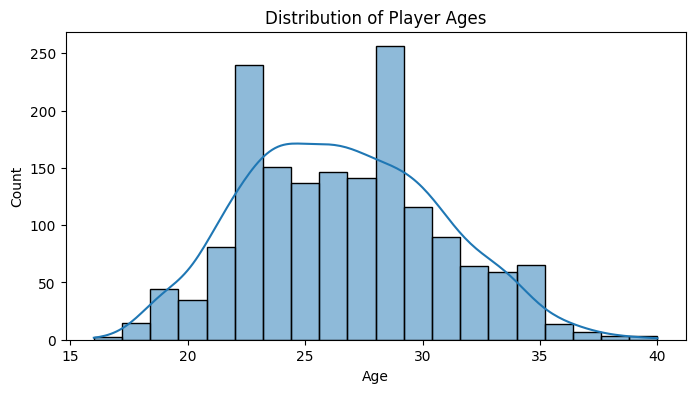

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Distribution of Player Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


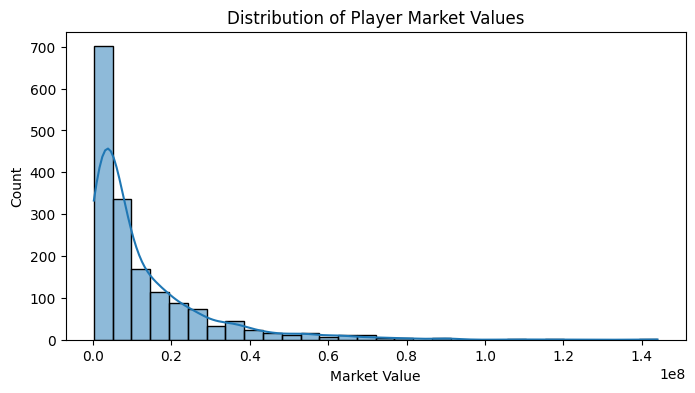

In [52]:
plt.figure(figsize=(8,4))
sns.histplot(df['Value'], bins=30, kde=True)
plt.title('Distribution of Player Market Values')
plt.xlabel('Market Value')
plt.ylabel('Count')
plt.show()


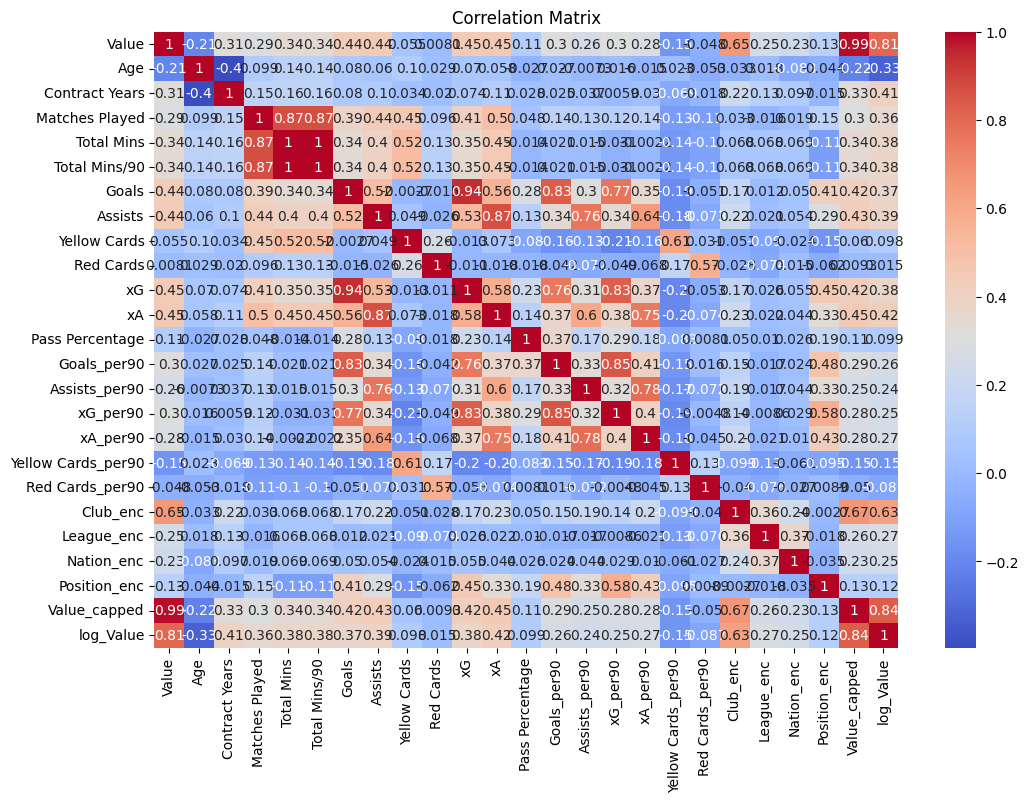

In [53]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


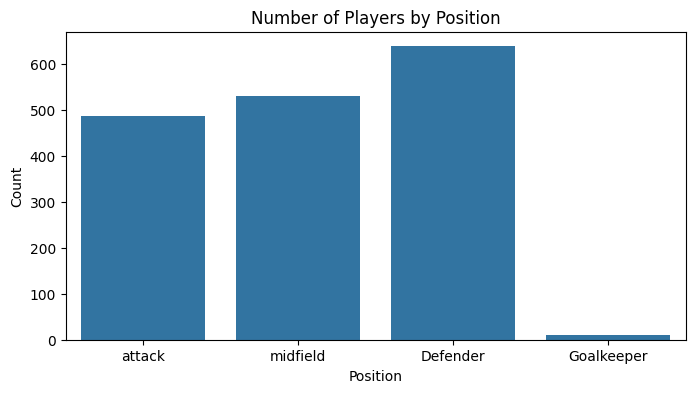

In [54]:
plt.figure(figsize=(8,4))
sns.countplot(x='Position', data=df)
plt.title('Number of Players by Position')
plt.xlabel('Position')
plt.ylabel('Count')
plt.show()


In [55]:
from scipy.stats import f_oneway

positions = df['Position'].unique()
groups = [df[df['Position'] == pos]['Value'] for pos in positions]
anova_result = f_oneway(*groups)
print("ANOVA F-value:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)


ANOVA F-value: 9.513141071201623
ANOVA p-value: 3.132536488531587e-06


In [56]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['Position'], df['League'])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-square statistic:", chi2)
print("p-value:", p)


Chi-square statistic: 11.490318285036633
p-value: 0.4874298826167289


In [43]:
features = [
    'Age', 'Contract Years', 'Matches Played', 'Total Mins', 'Pass Percentage',
    'Goals_per90', 'Assists_per90', 'xG_per90', 'xA_per90', 'Yellow Cards_per90', 'Red Cards_per90',
    'Club_enc', 'League_enc', 'Nation_enc', 'Position_enc'
]
target = 'log_Value'

X = df[features]
y = df[target]

print(X.shape, y.shape)
print(X.head())


(1669, 15) (1669,)
   Age  Contract Years  Matches Played  Total Mins  Pass Percentage  \
0   22             1.0            31.0      2380.0             48.0   
1   21             3.0            28.0      2407.0             52.2   
2   28             3.0            35.0      3082.0             35.1   
3   21             5.0            26.0      2062.0             29.4   
4   29             2.0            37.0      3078.0             38.3   

   Goals_per90  Assists_per90  xG_per90  xA_per90  Yellow Cards_per90  \
0     1.022727       0.265152  0.931818  0.174242            0.189394   
1     1.011236       0.224719  0.887640  0.202247            0.074906   
2     0.672515       0.409357  0.599415  0.216374            0.029240   
3     0.349345       0.480349  0.323144  0.296943            0.000000   
4     0.643275       0.146199  0.611111  0.184211            0.000000   

   Red Cards_per90      Club_enc    League_enc    Nation_enc  Position_enc  
0              0.0  2.488403e+07  8.67

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape, X_test_scaled.shape)


(1335, 15) (334, 15)


In [45]:
import xgboost as xgb

# Initialize and train the model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1
)
xgb_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test_scaled)


In [46]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# On log scale
r2_log = r2_score(y_test, y_pred)
print(f"XGBoost R² (log scale): {r2_log:.3f}")

# Back-transform predictions to original scale
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred)

# On original scale
r2_orig = r2_score(y_test_orig, y_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)

print(f"XGBoost R² (original scale): {r2_orig:.3f}")
print(f"XGBoost RMSE (original scale): {rmse_orig:,.0f}")
print(f"XGBoost MAE (original scale): {mae_orig:,.0f}")


XGBoost R² (log scale): 0.728
XGBoost R² (original scale): 0.640
XGBoost RMSE (original scale): 8,341,165
XGBoost MAE (original scale): 4,985,747


In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


cat_model = CatBoostRegressor(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function='RMSE',
    random_seed=42,
    verbose=0
)
cat_model.fit(X_train_scaled, y_train)
y_pred_cat = cat_model.predict(X_test_scaled)

print("CatBoost R² (log scale):", r2_score(y_test, y_pred_cat))
print("CatBoost R² (original scale):", r2_score(np.expm1(y_test), np.expm1(y_pred_cat)))
print("CatBoost RMSE :", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_cat))))
print("CatBoost MAE :", mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_cat)))


CatBoost R² (log scale): 0.7495825219610994
CatBoost R² (original scale): 0.6573687780832695
CatBoost RMSE (original): 8133493.11221955
CatBoost MAE (original): 4744228.506405761


In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("Random Forest R² (log scale):", r2_score(y_test, y_pred_rf))
print("Random Forest R² (original scale):", r2_score(np.expm1(y_test), np.expm1(y_pred_rf)))
print("Random Forest RMSE :", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_rf))))
print("Random Forest MAE :", mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_rf)))


Random Forest R² (log scale): 0.7209711585068385
Random Forest R² (original scale): 0.6415873954133757
Random Forest RMSE : 8318696.369036857
Random Forest MAE : 4852910.292868485


In [62]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    verbosity=-1  
)
lgb_model.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_model.predict(X_test_scaled)

print("LightGBM R² (log scale):", r2_score(y_test, y_pred_lgb))
print("LightGBM R² (original scale):", r2_score(np.expm1(y_test), np.expm1(y_pred_lgb)))
print("LightGBM RMSE :", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_lgb))))
print("LightGBM MAE :", mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_lgb)))


LightGBM R² (log scale): 0.7212176998195106
LightGBM R² (original scale): 0.6513693064971033
LightGBM RMSE : 8204392.814706234
LightGBM MAE : 4816024.464343259


c:\Program Files\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [63]:
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(
    estimators=[
        ('cat', cat_model),
        ('xgb', xgb_model),
        ('rf', rf)
    ],
    final_estimator=lgb.LGBMRegressor()
)
stack.fit(X_train_scaled, y_train)
y_pred_stack = stack.predict(X_test_scaled)
print("Stacked R² (log scale):", r2_score(y_test, y_pred_stack))
print("Stacked R² (original scale):", r2_score(np.expm1(y_test), np.expm1(y_pred_stack)))
print("Stacked R² RMSE :", np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_stack))))
print("Stacked R² MAE :", mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_stack)))


Stacked R² (log scale): 0.7144866938977847
Stacked R² (original scale): 0.6264767350546654
Stacked R² RMSE : 8492244.00718483
Stacked R² MAE : 5090727.9923629165


c:\Program Files\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


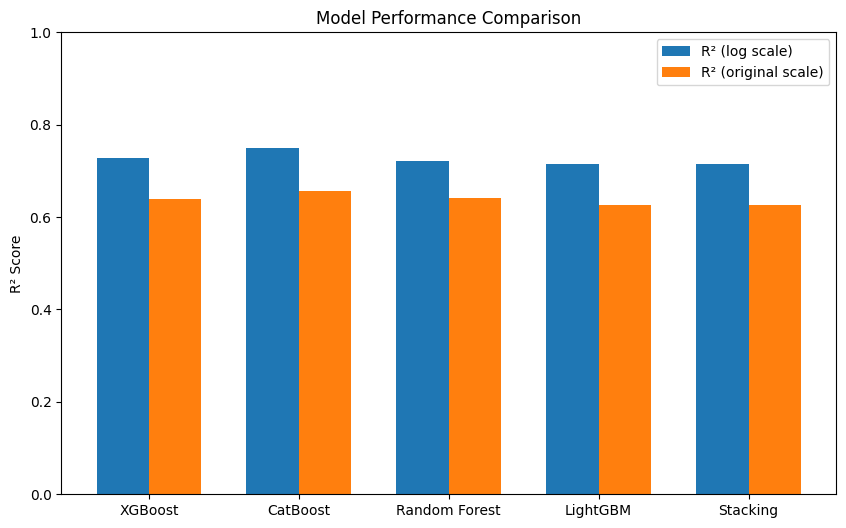

In [ ]:
import numpy as np

models = ['XGBoost', 'CatBoost', 'Random Forest', 'LightGBM', 'Stacking']
r2_log = [0.728, 0.750, 0.721, 0.714, 0.714]  
r2_orig = [0.640, 0.657, 0.642, 0.626, 0.626] 

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, r2_log, width, label='R² (log scale)')
rects2 = ax.bar(x + width/2, r2_orig, width, label='R² (original scale)')

ax.set_ylabel('R² Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.ylim(0, 1)
plt.show()


In [64]:
'''Among working with different models CatBoost model is performed well and XGBoost and Random Forest are equally performed. To be precise every model used on this data is worked fine and every value is very marginal difference between them.We trained several machine learning regression models to predict football players’ market values using features like age, position, club, and performance stats. The best model (CatBoost) explains about 75% of the variance in market values. The most important features are goals per 90, age, and club. This model can forecast market values for current and new players, helping clubs and agents make data-driven decisions. However, it cannot predict unpredictable events like injuries or sudden market changes, and should be retrained regularly with new data.”

'''

'Among working with different models CatBoost model is performed well and XGBoost and Random Forest are equally performed. To be precise every model used on this data is worked fine and every value is very marginal difference between them.We trained several machine learning regression models to predict football players’ market values using features like age, position, club, and performance stats. The best model (CatBoost) explains about 75% of the variance in market values. The most important features are goals per 90, age, and club. This model can forecast market values for current and new players, helping clubs and agents make data-driven decisions. However, it cannot predict unpredictable events like injuries or sudden market changes, and should be retrained regularly with new data.”\n\n'

In [65]:
# Example input for a new player (replace with actual values)
new_player = pd.DataFrame({
    'Age': [23],
    'Contract Years': [2],
    'Matches Played': [30],
    'Total Mins': [2500],
    'Pass Percentage': [78.0],
    'Goals_per90': [0.5],
    'Assists_per90': [0.2],
    'xG_per90': [0.4],
    'xA_per90': [0.15],
    'Yellow Cards_per90': [0.05],
    'Red Cards_per90': [0.01],
    'Club_enc': [1.2e7],      # Use your encoding or mapping
    'League_enc': [2.5e6],
    'Nation_enc': [3.1e6],
    'Position_enc': [4.0e6]
})


In [66]:
new_player_scaled = scaler.transform(new_player)


In [73]:
log_value_pred = cat_model.predict(new_player_scaled)
predicted_value = np.expm1(log_value_pred)  # Back-transform from log scale
print(f"Predicted Market Value By CatBoost Model: €{predicted_value[0]:,.0f}")


Predicted Market Value By CatBoost Model: €18,705,240


In [69]:
log_value_pred = xgb_model.predict(new_player_scaled)
predicted_value = np.expm1(log_value_pred)  # Back-transform from log scale
print(f"Predicted Market Value By XGBoost Model: €{predicted_value[0]:,.0f}")

Predicted Market Value By XGBoost Model: €19,911,812


In [70]:
log_value_pred = lgb_model.predict(new_player_scaled)
predicted_value = np.expm1(log_value_pred)  # Back-transform from log scale
print(f"Predicted Market Value LightGBM Model: €{predicted_value[0]:,.0f}")

Predicted Market Value LightGBM Model: €19,024,678


c:\Program Files\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [71]:
log_value_pred = rf.predict(new_player_scaled)
predicted_value = np.expm1(log_value_pred)  # Back-transform from log scale
print(f"Predicted Market Value By Random Forest Model: €{predicted_value[0]:,.0f}")

Predicted Market Value By Random Forest Model: €21,957,332


In [72]:
log_value_pred = stack.predict(new_player_scaled)
predicted_value = np.expm1(log_value_pred)  # Back-transform from log scale
print(f"Predicted Market Value By Stacked R2 Model: €{predicted_value[0]:,.0f}")

Predicted Market Value By Stacked R2 Model: €18,057,682


c:\Program Files\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [80]:
column_dtypes_dict = dict(zip(df.columns, df.dtypes))
print(column_dtypes_dict)

{'Player': dtype('O'), 'Club': dtype('O'), 'Value': dtype('int64'), 'Age': dtype('int64'), 'Position': dtype('O'), 'Nation': dtype('O'), 'Contract Years': dtype('float64'), 'League': dtype('O'), 'Matches Played': dtype('float64'), 'Total Mins': dtype('float64'), 'Total Mins/90': dtype('float64'), 'Goals': dtype('float64'), 'Assists': dtype('float64'), 'Yellow Cards': dtype('float64'), 'Red Cards': dtype('float64'), 'xG': dtype('float64'), 'xA': dtype('float64'), 'Pass Percentage': dtype('float64'), 'Goals_per90': dtype('float64'), 'Assists_per90': dtype('float64'), 'xG_per90': dtype('float64'), 'xA_per90': dtype('float64'), 'Yellow Cards_per90': dtype('float64'), 'Red Cards_per90': dtype('float64'), 'Club_enc': dtype('float64'), 'League_enc': dtype('float64'), 'Nation_enc': dtype('float64'), 'Position_enc': dtype('float64'), 'Value_capped': dtype('float64'), 'log_Value': dtype('float64')}


In [81]:
# Export the DataFrame to CSV with headers (matching your column names)
df.to_csv('football_players_for_sql.csv', index=False)
